<a href="https://colab.research.google.com/github/dancher00/Experimental-Data-Analysis/blob/main/joint_assimilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 9
## Joint assimilation of navigation data coming from different sources
Team 1:
- **Danil Belov**
- **Alexey Kotcov**
- **Roman Khalikov**


As always we were working as team and all of us were very involved.

**Even Power Rangers was not as efficient as we are.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(44)

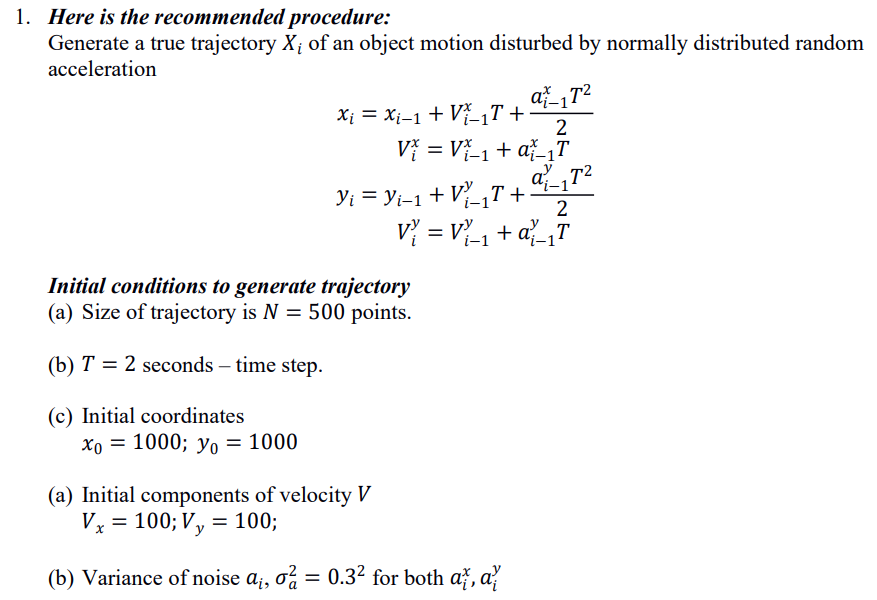

In [ ]:
x_0 = 1000

v_0 = 100

t = 2
n = 500

sigma_a = 0.3

sigma_d = 50
sigma_b = 0.004
sigma_bb = 0.001

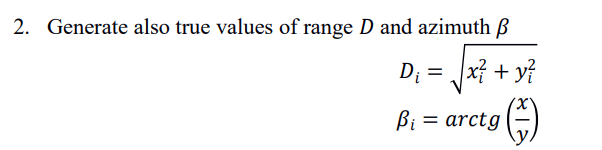

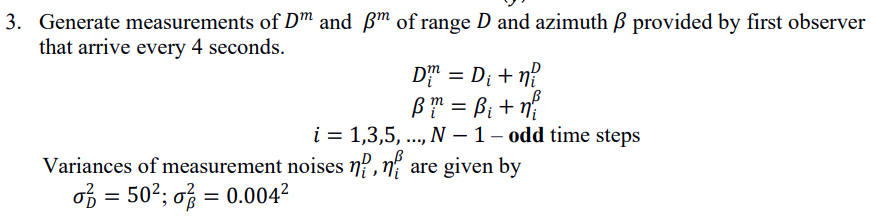

In [ ]:
def generate_trajectory():

    a = np.random.normal(0, sigma_a, size = (n, 2))
    v = np.zeros((n, 2))
    x = np.zeros((n, 2))

    v[0] = [v_0, v_0]
    x[0] = [x_0, x_0]

    for i in range(1, n):
        v[i] = v[i-1] + a[i-1] * t

    for i in range(1, n):
        x[i] = x[i-1] + v[i-1] * t + a[i-1] * t**2 /2

    x_ = x.T

    d = np.sqrt(np.sum(x_**2, axis=0))
    b = np.arctan2(x_[0], x_[1])

    eta_d = np.random.normal(0, sigma_d, int(len(d)/2))
    eta_b = np.random.normal(0, sigma_b, int(len(b)/2))
    add_b = np.random.normal(0, sigma_bb, int(len(b)/2))

    d_m = np.zeros_like(d)
    b_m = np.zeros_like(b)


    d_m[0] = d[0]
    b_m[0] = b[0]


    for i in range(1,n,2):
        d_m[i] = d[i] + eta_d[int(i/2)]
        b_m[i] = b[i] + eta_b[int(i/2)]
        if(i!=499):
          d_m[i+1] = np.nan

    for i in range(4,n,2):
        b_m[i] = b[i] + add_b[int(i/2)]

    z_p = np.array([d_m, b_m])

    for i in range(n-1):
      if np.isnan(z_p[0,i]):
        z_p[0,i] = z_p[0,i+1]


    z_c = np.array([z_p[0,:] * np.sin(z_p[1,:]), z_p[0,:] * np.cos(z_p[1,:])])

    return x_, d, b, z_p, z_c

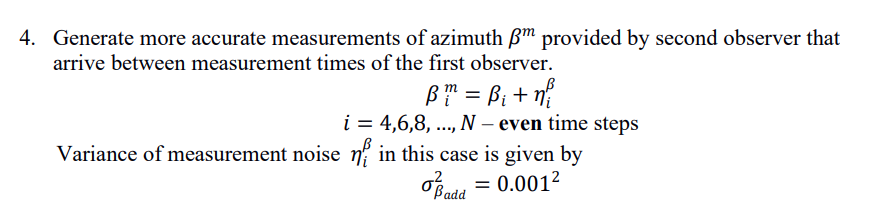

In [ ]:
x_, d, b, z_p, z_c = generate_trajectory()

In [ ]:
z_p.shape

(2, 500)

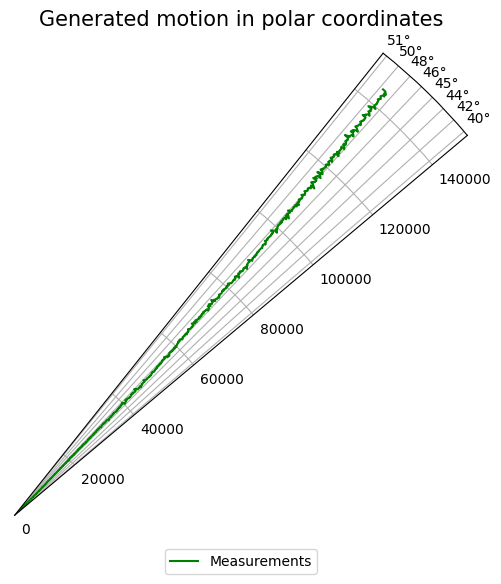

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':'polar'}, figsize=(6,6))
plt.title('Generated motion in polar coordinates', size=15)
ax.plot(z_p[1], z_p[0], color='g', label='Measurements')
ax.set_thetalim([np.pi/4.5, np.pi/3.5])

ax.legend(loc='center', bbox_to_anchor=(0.5,-0.1))

plt.show()

As we can see from the plot we succesfully **made** our **trajectory generation** function and measurements are noisy as usual!

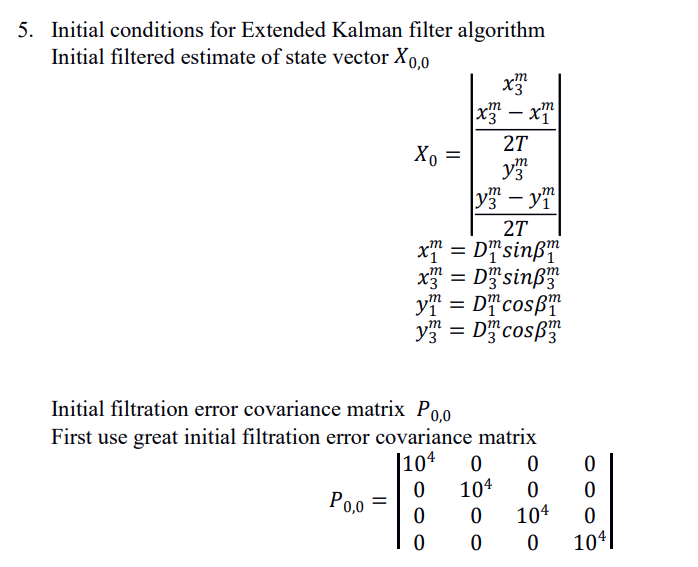

In [ ]:
P_fil = np.eye(4) * 10**4

H = np.array([[1,0,0,0],[0,0,1,0]])

F = np.eye(4)
F[0,1] = t
F[2,3] = t

G = np.zeros((4,2))
G[0,0] = t**2 / 2
G[1,0] = t
G[2,1] = t**2 / 2
G[3,1] = t

Q = G @ G.T * sigma_a**2

R = np.array([[sigma_d**2,0],
              [0, sigma_b**2]])

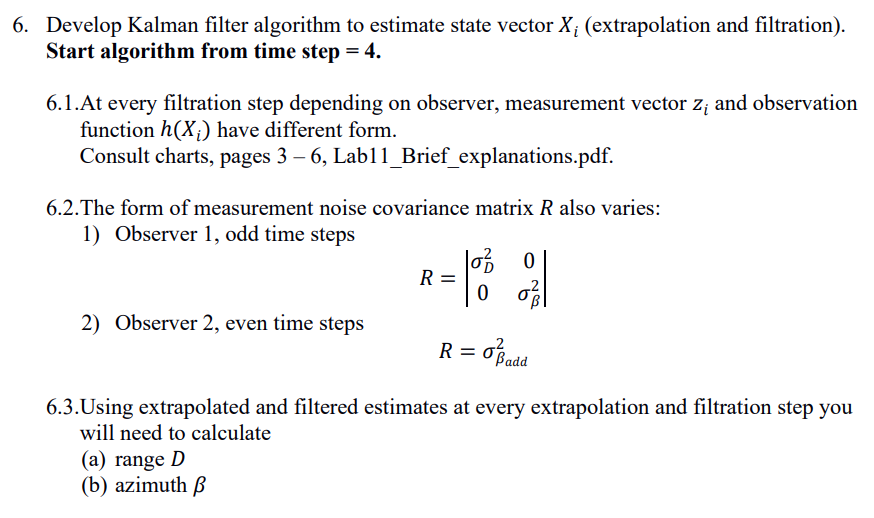

In [ ]:
def h(x):
  return np.array([[np.sqrt(x[0][0]**2 + x[2][0]**2)],
                   [  np.arctan2(x[0][0], x[2][0])  ]])

def dh(x):
  return np.array([[x[0][0]/np.sqrt(x[0][0]**2 + x[1][0]**2), 0, x[2][0] / np.sqrt(x[0][0]**2 + x[1][0]**2), 0],
                   [x[2][0]/(x[0][0]**2 + x[1][0]**2),        0, -x[0][0]/(x[0][0]**2 + x[1][0]**2),         0]])

  In the task it is stated, that algorithm must be started from step=4, so range was set **(4,n)**.
  
  All other Kalman filter calculations was taken from our **previous assignment**.

In [ ]:
    X = np.array(([z_p[0][0] * np.sin(z_p[1][0])],
                            [0],
                  [z_p[0][0] * np.cos(z_p[1][0])],
                            [0]                  ))

In [ ]:
X

array([[1000.],
       [   0.],
       [1000.],
       [   0.]])

In [ ]:
def kalman(z_p, z_c):

    x_k = np.zeros((n, 4))

    K_arr = np.zeros(n)

    d_ext_arr = np.zeros(n, dtype='float64')
    b_ext_arr = np.zeros(n, dtype='float64')
    d_fil_arr = np.zeros(n, dtype='float64')
    b_fil_arr = np.zeros(n, dtype='float64')

    X = np.array(([z_p[0][0] * np.sin(z_p[1][0])],
                            [0],
                  [z_p[0][0] * np.cos(z_p[1][0])],
                            [0]                  ))


    P_fil = np.eye(4) * 10**10

    for i in range(4,n):
        X = F @ X

        # print(X)

        P_pred = F @ P_fil @ F.T + Q

        H = dh(X)


        d_ext = np.sqrt(X[0]**2 + X[2]**2)
        # print(X[0])
        b_ext = np.arctan2(X[0], X[2])


        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        P_fil = (np.eye(np.shape(P_pred)[0]) - K @ H) @ P_pred
        X = X + K @ (z_p[:,i:(i+1)] - h(X))

        d_fil = np.sqrt(X[0]**2 + X[2]**2)
        b_fil = np.arctan2(X[0], X[2])

        x_k[i] = X.T
        K_arr[i] = K[0][0]

        d_ext_arr[i] = d_ext
        b_ext_arr[i] = b_ext
        d_fil_arr[i] = d_fil
        b_fil_arr[i] = b_fil

    return d_ext_arr, b_ext_arr, d_fil_arr, b_fil_arr

In [ ]:
d_ext_arr, b_ext_arr, d_fil_arr, b_fil_arr = kalman(z_p, z_c)

In [ ]:
d_ext_arr.shape

(500,)

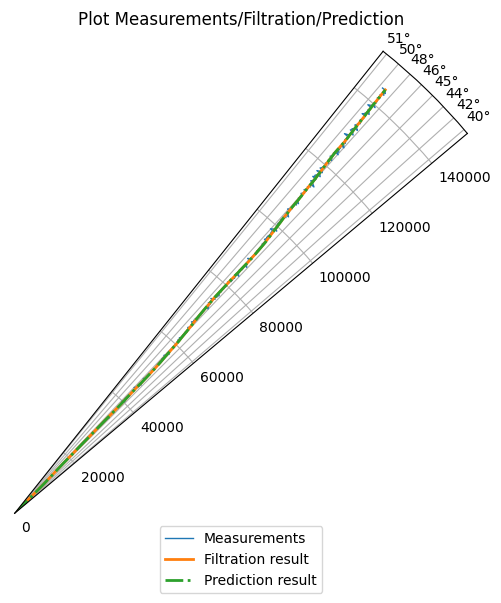

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,6))
plt.title('Plot Measurements/Filtration/Prediction')
ax.plot(z_p[1,:], z_p[0,:], linewidth = 1, label = 'Measurements')
ax.plot(b_fil_arr, d_fil_arr, linewidth = 2, label = 'Filtration result')
ax.plot(b_ext_arr, d_ext_arr, linewidth = 2, label = 'Prediction result', linestyle='dashdot')
ax.set_thetalim([np.pi/4.5, np.pi/3.5])
ax.legend(loc='center', bbox_to_anchor=(0.5,-0.1))
plt.show()

As we can see from the plot prediction and filtration **works very well**. And as it was previously we can notice that filtration graph and prediction graph are almost the same, but I want you to be sure - **they are different**.

We checked that by substracting one from another.

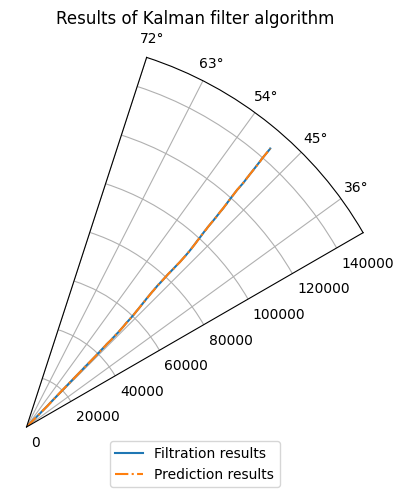

In [ ]:
plt.polar(b_fil_arr, d_fil_arr, label = 'Filtration results')
plt.polar(b_ext_arr, d_ext_arr, label = 'Prediction results', linestyle='dashdot')
plt.xlim([np.pi/6,np.pi/2.5])

plt.title('Results of Kalman filter algorithm')
plt.legend(loc='center', bbox_to_anchor=(0.5,-0.1))
plt.show()

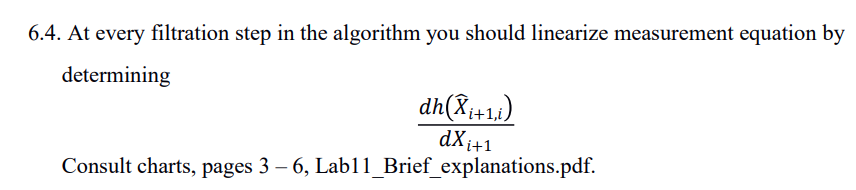

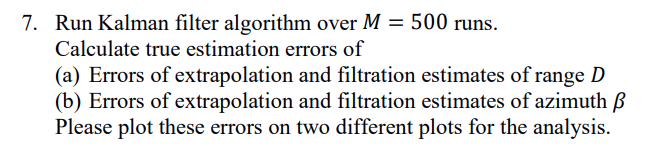

In [ ]:
M = 500

error_D_ext =  np.zeros(M)
error_D_fil =  np.zeros(M)

error_b_ext =  np.zeros(M)
error_b_fil =  np.zeros(M)

for i in range(M):


    x_, d, b, z_p, z_c = generate_trajectory()
    d_ext_arr, b_ext_arr, d_fil_arr, b_fil_arr = kalman(z_p, z_c)



    error_D_ext += (d_ext_arr - z_p[0])**2
    error_D_fil += (d_fil_arr - z_p[0])**2

    error_b_ext += (b_ext_arr - z_p[1])**2
    error_b_fil += (b_fil_arr - z_p[1])**2


error_D_ext_f = np.sqrt((error_D_ext)/(M-1))[2:]
error_D_fil_f = np.sqrt((error_D_fil)/(M-1))[2:]

error_b_ext_f = np.sqrt((error_b_ext)/(M-1))[2:]
error_b_fil_f = np.sqrt((error_b_fil)/(M-1))[2:]

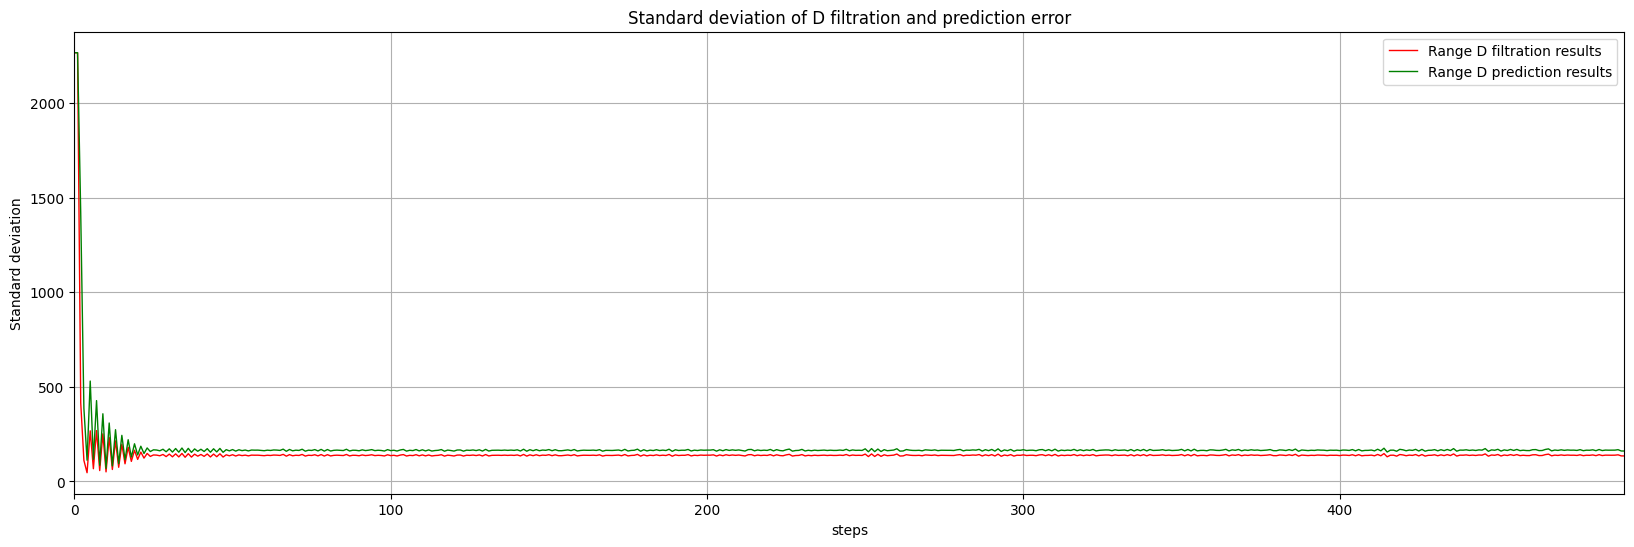

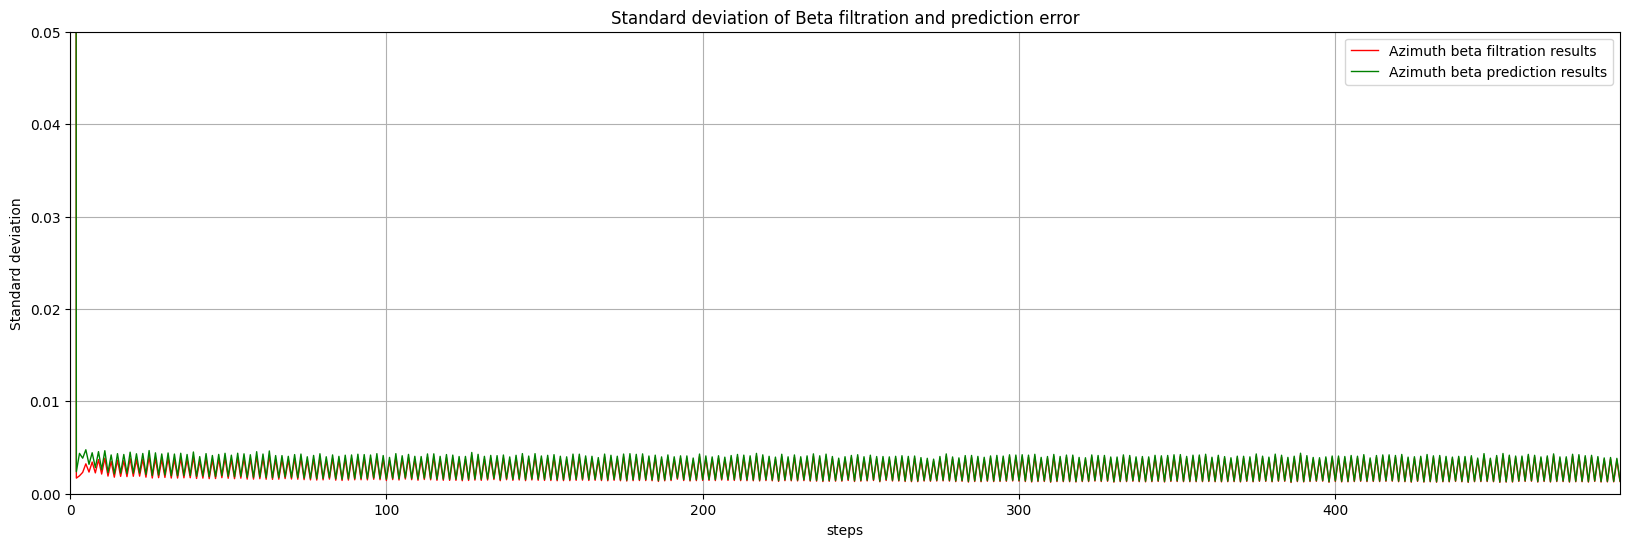

In [ ]:
fig, ax10 = plt.subplots(figsize=(20, 6))
ax10.plot(error_D_fil_f, color='red', label='Std Dev of estimation error for D', linewidth = 1)
ax10.plot(error_D_ext_f, color='green', label='Std Dev of prediction error for D', linewidth = 1)
plt.grid(True)
plt.xlabel('steps')
plt.ylabel('Standard deviation')
plt.title('Standard deviation of D filtration and prediction error')
plt.xlim([0, n-10])
leg = ax10.legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=1)
plt.legend(['Range D filtration results','Range D prediction results'])
plt.show()

fig, ax101 = plt.subplots(figsize=(20, 6))
ax101.plot(error_b_fil_f, color='red', label='Std Dev of estimation error for Beta', linewidth = 1)
ax101.plot(error_b_ext_f, color='green', label='Std Dev of prediction error for Beta', linewidth = 1)
plt.grid(True)
plt.xlabel('steps')
plt.ylabel('Standard deviation')
plt.title('Standard deviation of Beta filtration and prediction error')
plt.legend(['Azimuth beta filtration results','Azimuth beta prediction results'])
plt.ylim([0, 0.05])
plt.xlim([0, n-10])
leg = ax10.legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=1)
plt.show()

Looking at the result graphs we can say that standart deviation of predicted values just a little bit more than filtration ones for both range D and azimuth beta. And the thing that firstly pops up - **standard deviation of azimuth beta is very very small**.

**Conclusions**: from the first assignment to this one we were collecting all necessary tools for performing these calculations and now we are learning about variety of initial conditions. A bit tricky was the part where we needed to get rid of nan values for range D, but after some brain trainings we made it - we just filled these empty slots with its neighbours.